# Thermodynamic Features

Andrew Weng

8/25/2022

Workspace to demonstrate various methods to convert various forms of battery degradation parameters into full cell equilibrium potential curves.

Requirements:

- Cathode OCV curve data
- Anode OCV curve data

Half-cell OCV curve data could either be empirical or a function. This notebook assumes that we have a mathematical function to descrive each curve, e.g. $U_p = U_p(y)$ where $y \in (0,1)$ is the positive electrode stoichiometry. Similarly, $U_n = U_n(x)$ where $ x \in (0, 1)$.

Empirical functions of half cells can also be given as an interpolating function.

## Models

#### 'LAM' Basis

- State vector: $[\mathrm{LAM}_\mathrm{NE}, \mathrm{LAM}_\mathrm{PE}, \mathrm{LLI}]^T$
- Consists of normalized losses of active material in the positive and negative electrodes, as well as loss of lithium inventory.
- All quantities are expressed as percentages relative to a 'fresh cell' quantity.

####  'DEG'(radation) Basis

- State vector: $[C_n, C_p, n_{\mathrm{Li}}]^T$
- Consists of absolute pos. and neg. active material capacities, as well as lithium inventory (in moles).

#### 'ESOH' Basis

- State vector: $[x_{100}, y_{100}, C_n, C_p, C]^T$, or equivalently, $[x_{0}, y_{0}, C_n, C_p, C]^T$.

#### 'VOC' Basis

- State vector: $[q, V_{oc}(q), U_n(q), U_p(q)]^T$
- Main basis for making the plots

### Basis Transformations

It is possible to interchange between each basis state.

A: 'LAM' to 'DEG'

\begin{align}
    C_n &= C_{n,0} (1 - \mathrm{LAM}_\mathrm{NE}) \\
    C_p &= C_{p,0} (1 - \mathrm{LAM}_\mathrm{PE}) \\
    n_{\mathrm{Li}} & = n_{\mathrm{Li},0}(1 - \mathrm{LLI})
\end{align}

B: 'DEG' to 'ESOH'




C: 3 --> 4


In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')
    
import numpy as np
import pandas as pd
import yaml
from matplotlib import pyplot as plt

import src.plotter as plotter
import src.dvdq as dvdq

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

plotter.initialize(plt)

# Set paths
paths = yaml.load(open('paths.yaml', 'r'), Loader=yaml.FullLoader)
output_path = f"{paths['outputs']}/2022-08-25-manufacturing-features"

Text(0, 0.5, 'U (V vs Li/Li$^+$)')

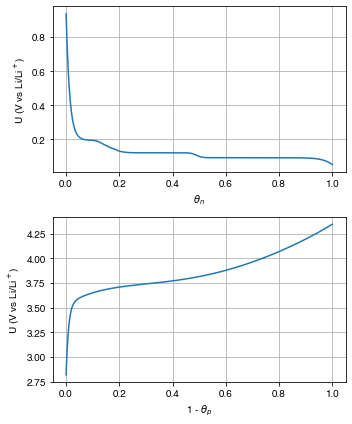

In [3]:
theta_n = np.linspace(0, 1, 1000)
theta_p = np.linspace(0, 1, 1000)

ocv_neg = dvdq.f_neg_ocv(theta_n)
ocv_pos = dvdq.f_pos_ocv(theta_p)

plt.figure(figsize=(5, 6))

plt.subplot(2, 1, 1)
plt.plot(theta_n, ocv_neg)
plt.xlabel(r'$\theta_n$')
plt.ylabel('U (V vs Li/Li$^+$)')
plt.subplot(2, 1, 2)
plt.plot(1 - theta_p, ocv_pos)
plt.xlabel(r'1 - $\theta_p$')
plt.ylabel('U (V vs Li/Li$^+$)')

## Demonstration of converting eSOH metrics to OCV

<ipython-input-23-990e4c0ecccf>:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{output_path}/fig_thermodynamic_features.png', dpi=300)


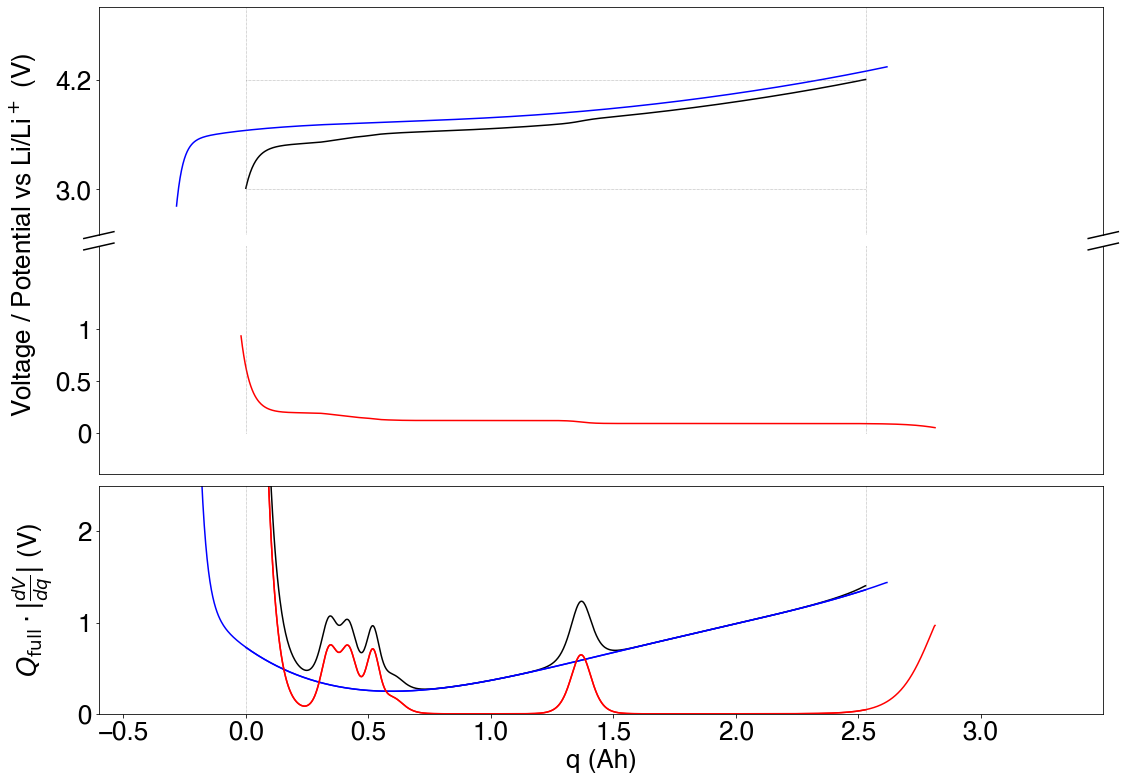

In [23]:
Cp = 2.90 # Ah
Cn = 2.833
x100 = 0.90
y100 = 0.03

qmax = 2.53 # Ah

x0 = x100 - qmax/Cn
y0 = y100 + qmax/Cp

y_vec = np.linspace(0, 1, 1000)
x_vec = np.linspace(0, 1, 1000)

qpos = Cp*(y0 - y_vec)
vpos = dvdq.f_pos_ocv(y_vec)
qneg = Cn*(x_vec - x0)
vneg = dvdq.f_neg_ocv(x_vec)

# Full cell capacity
q = np.linspace(0, qmax, 1000)

(Voc, Up, Un) = dvdq.esoh_to_voc(x100, y100, Cn, Cp, q)

plotter.initialize(plt)

gridspec = dict(hspace=0.05, height_ratios=[1, 1, 1])

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, 
                                gridspec_kw=gridspec, 
                                figsize=(18, 13))

# Make the cathode and full cell voltage plot
ax1.plot(q, Voc, 'k')
ax1.plot(qpos, vpos, 'b')
ax1.set_ylim((2.5, 5))
ax1.set_ylabel('Voltage / Potential vs Li/Li$^+$ (V)')
ax1.set_yticks([3, 4.2])
ax1.hlines([3.0, 4.2], np.min(q), np.max(q), 
            color=(0.4, 0.4, 0.4), linewidth=0.5, linestyle=':')
ax1.set_xticklabels([])
ax1.set_xticks([])
ax1.yaxis.set_label_coords(-0.06, 0.00)
ax1.spines['bottom'].set_visible(False)

# Make the anode voltage plot
ax2.spines['top'].set_visible(False)
ax2.plot(qneg, vneg, 'r')
ax2.set_ylim((-0.4, 1.8))
ax2.set_yticks([0, 0.50, 1])
ax2.set_yticklabels([0, 0.50, 1])
ax2.set_xticklabels([])
ax2.set_xticks([])

# Make the split lines
d = 0.015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d,+d), (-d,+d), **kwargs)
ax1.plot((1-d,1+d),(-d,+d), **kwargs)

kwargs.update(transform=ax2.transAxes, color='k', clip_on=False) 
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((1-d,1+d), (1-d,1+d), **kwargs)

# Make the dV/dQ plot
ax3.plot(q, np.gradient(Voc)/np.gradient(q)*np.max(q), 'k')
ax3.plot(q, np.gradient(Up)/np.gradient(q)*np.max(q), 'b')
ax3.plot(qpos, np.gradient(vpos)/np.gradient(qpos)*np.max(q), 'b')
ax3.plot(q, -np.gradient(Un)/np.gradient(q)*np.max(q), 'r')
ax3.plot(qneg, -np.gradient(vneg)/np.gradient(qneg)*np.max(q), 'r')
ax3.yaxis.set_label_coords(-0.045, 0.00)
ax3.set_xlabel('q (Ah)')
ax3.set_xticks([-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3])
ax3.set_ylabel(r'$Q_{\mathrm{full}}\left|\frac{dV}{dq}\right|$ (V)')
ax3.set_ylim((0, 2.5))

# Set shared axis settings
for ax in [ax1, ax2, ax3]:
    ax.set_xlim((-0.6, 3.5))
    ax.grid(False)
    ax.vlines(x=[0, np.max(q)], ymin=0, ymax=5, 
              color=[0.4, 0.4, 0.4], linewidth=0.5,
              linestyle=':')

plt.savefig(f'{output_path}/fig_thermodynamic_features.png', dpi=300)

## Demonstration of the graphical approach

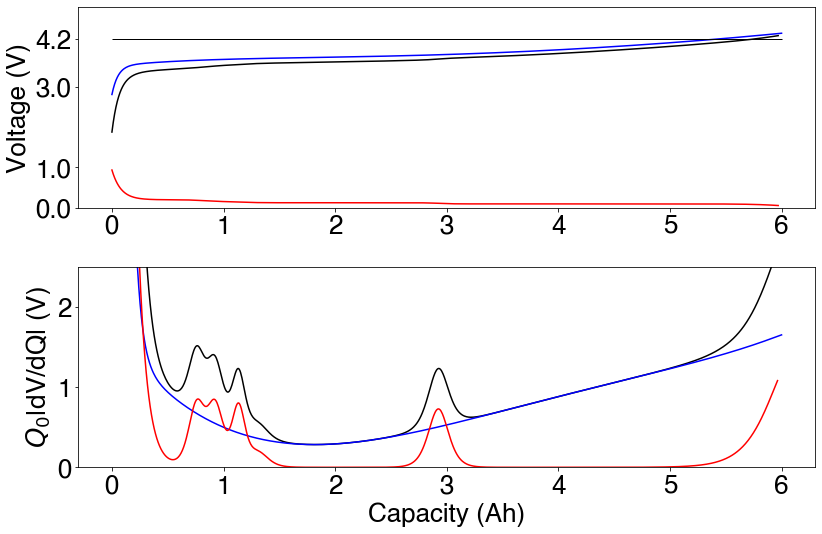

In [ ]:
lli = 0.0
lam_pe = 0.0
lam_ne = 0.0
Cn = 5.97
Cp = 6.00

(Voc, Un, Up, cap) = dvdq.deg_to_voc_graphical(lam_pe, lam_ne, lli, Cp, Cn)

dvdq.make_plot(cap, Voc, Up, Un)